# Plotting a Time Series of HMDA Filers by Category

### Scope of Notebook
This notebook will build on the [previous analysis example](https://github.com/cfpb/HMDA_Data_Science_Kit/blob/master/analysis_examples/1.%20Plotting%20a%20Time%20Series%20of%20HMDA%20Filers%20from%202004-2017.ipynb) of counting the number of institutions that have filed HMDA data from 2004-2017, by demonstrating how to filter counts by a particular category. The code below will focus on counts taken from the Transmittal Sheet dataset inside the HMDA collections.

The example will show how to pull Transmittal Sheet data from a local Postgres database, filter by a particular category, write the data to a pipe-delimited text file, and produce a graph in the Jupyter notebook as well as save the graph to a .png file.

Additionally, more advanced methods using functions will be shown as an introduction to a library of functions that can be used to interact with the HMDA data.

While these examples provide some commentary on the use of SQL and Python, they should not be considered a replacement for more full fledged tutorials on how to use these tools. 

### Setup Requirements
In order to run this example locally several software packages need to be installed and configured. 
Please see [these instructions](https://github.com/Kibrael/HMDA_Data_Science_Kit#creating-postgres-tables-and-loading-data) to get a local Postgres database set up and populated with HMDA data. 
Please see [these instructions](https://github.com/Kibrael/HMDA_Data_Science_Kit#requirements) for setting up a Python development environment. Python 3.5 or higher is required as well as several libraries.


### Python Libraries Used
- [Pandas](https://pandas.pydata.org/pandas-docs/stable/): a data manipulation and analysis package.
- [Psycopg2](http://initd.org/psycopg/docs/): a database driver library providing APIs for connecting Python to Postgres.
- [Matplotlib](https://matplotlib.org/): a library to enable inline plotting with Pandas and Jupyter notebooks.
- [Jupyter](http://jupyter.org/documentation): a development tool that supports multiple formats for display such as Markdown and Python. Allows segmentation of code into cells for easy data manipulation trials.

### Approach
This notebook will leverage Postgres SQL as a data store and aggregation tool. Python will be used to interact with the database through the Psycopg2 library. The Pandas library will be used for data handling after pulling from Postgres. This includes cleaning, analysis, and visualization with the Matplotlib library (which integrates with Pandas).

The procss for this analysis will be:
- Establish a connection to the database using psycopg2
- Call a SQL file through Python to pull Transmittal Sheet counts by year
- Filter by a particular category
- Load the data into a Pandas dataframe
- Graph the data in the Jupyter notebook and save the graph to a .PNG file

## Import Python Libraries

In [2]:
import psycopg2 #Imports the Psycopg2 library
import pandas as pd #Imports the Pandas library and renames it "pd"
import matplotlib.pyplot as plt #imports the Matplot library and renames it "plt"

### Connect to the Database
The connection to the database, which was demonstrated in the [previous example](https://github.com/cfpb/HMDA_Data_Science_Kit/blob/master/analysis_examples/1.%20Plotting%20a%20Time%20Series%20of%20HMDA%20Filers%20from%202004-2017.ipynb), will use a locally hosted database and the hmda database created during initial setup. Please see Analysis Example 1 for further details on connecting using a locally hosted database. 

In [3]:
#Establish connection parameters
#If you have established a username and password, change user and password below to your own username and password.
connection_params = {"user":"postgres", 
                     "password":"helloworld", 
                     "dbname":"hmda", 
                     "host":"localhost",
                     "port" : "5433"}

In [4]:
def connect(params):
    """
    This function accepts a dictionary of connection parameters that must include:
    - user: the username to be used for the database session
    - password: the user's password
    - dbname: the name of the database for connection
    - host: the host location of the database
    """
    #attempt a connection with the supplied parameters
    try:
        conn = psycopg2.connect(**params)
        print("I'm connected") #print a success message
        return conn.cursor() #return a cursor object
    except psycopg2.Error as e: 
        print("I am unable to connect to the database: ", e) #print a fail message and the error, if any

In [5]:
#Test the connection function, if everything is correct, it will print "I'm connected."
cur = connect(params=connection_params)
#Close the cursor. This is important as open cursors can interfere with updates to data tables.
cur.close()

#When using Jupyter, it is best to open and close the cursor in the same code cell. 
#If there are coding errors that interrupt the execution, the cursor will need to be reestablished. 


I'm connected


### Variabalizing a SQL Command String for Filtering
As demonstrated in the previous example, Python strings can contain markers which enable substitution of values. This allows use of the .format() command to change the table reference for the SQL query. The string below selects the activity year and the filer count, variabalizing the year.   

In [11]:
sql_command = """SELECT 
                    activity_year, 
                    COUNT (*) AS filer_count
                 FROM 
                    hmda_public.ts_{year} 
                 GROUP BY 
                    activity_year;"""

A SQL command string may be modified to select a count of filers by a given category. The command string below not only variabalizes the year of the file to be selected but also creates an extention to the query that may be modified by the user.  

In [6]:
sql_base = """SELECT CONCAT(lar_{year}.state_code,lar_{year}.county_code) AS fips,
           count(case when lar_{year}.loan_purpose = '1' then 1 else null end) as prps_prch,
           count(case when lar_{year}.loan_purpose = '2' then 1 else null end) as prps_impr,
           count(case when lar_{year}.loan_purpose = '3' then 1 else null end) as prps_refi
            FROM lar_{year} {extention}
            ;"""

In [7]:
extention = "GROUP BY state_code,county_code"
 

### Selecting the Number of Filers by a Particular State
The code above may be placed in another sql file, which may be called by the the time series function defined in the previous example. The code below may be used to select for the number of filers who have their headquarters in New York. Respondent_state refers to the headquarters location of the institution and does not necessarily reflect lending patterns in that geography.

In [ ]:
cur = connect(connection_params) #Establishes cursor object and connect to the database
year = 2016

#Provides the year of the file 

#Sets the extention variable so that it selects filers in the state of New York
print(sql_base.format(year=year, extention=extention))
 
#Executes the query text against the database, formatting for the year and the extention
cur.execute(sql_base.format(year=year, extention=extention))
results = cur.fetchall() #Returns the query results.
#print(results)
print(cur.description)
#Converts the results_list into a Pandas dataframe with names pulled from the SQL query.
results_df = pd.DataFrame(results, columns=[desc[0] for desc in cur.description])
cur.close() #Closes the connection and remove the cursor object.
#results_df.head() #Shows the top 5 rows of the dataframe

I'm connected
SELECT CONCAT(lar_2016.state_code,lar_2016.county_code) AS fips,
           count(case when lar_2016.loan_purpose = '1' then 1 else null end) as prps_prch,
           count(case when lar_2016.loan_purpose = '2' then 1 else null end) as prps_impr,
           count(case when lar_2016.loan_purpose = '3' then 1 else null end) as prps_refi
            FROM lar_2016 GROUP BY state_code,county_code
            ;


In [28]:
cur = connect(connection_params) #Establishes cursor object and connect to the database
year = 2005

#Provides the year of the file 

#Sets the extention variable so that it selects filers in the state of New York
extention = " GROUP BY activity_year, respondent_state"
 
#Executes the query text against the database, formatting for the year and the extention
cur.execute(sql_base.format(year=year, extention=extention))
results = cur.fetchall() #Returns the query results.
print(results)

#Converts the results_list into a Pandas dataframe with names pulled from the SQL query.
results_df = pd.DataFrame(results, columns=[desc[0] for desc in cur.description])
cur.close() #Closes the connection and remove the cursor object.
#results_df.head() #Shows the top 5 rows of the dataframe

I'm connected


ProgrammingError: column "respondent_state" does not exist
LINE 5: ...           FROM lar_2005  GROUP BY activity_year, respondent...
                                                             ^


In [14]:
cur = connect(connection_params) #Establishes cursor object and connect to the database
year = 2006

#Provides the year of the file 

#Sets the extention variable so that it selects filers in the state of New York
extention = " GROUP BY activity_year, respondent_state"
 
#Executes the query text against the database, formatting for the year and the extention
cur.execute(sql_base.format(year=year, extention=extention))
results = cur.fetchall() #Returns the query results.
print(results)

#Converts the results_list into a Pandas dataframe with names pulled from the SQL query.
results_df = pd.DataFrame(results, columns=[desc[0] for desc in cur.description])
cur.close() #Closes the connection and remove the cursor object.
#results_df.head() #Shows the top 5 rows of the dataframe

I'm connected
[('2006', 'DE', 26), ('2006', 'HI', 25), ('2006', 'MA', 299), ('2006', 'KS', 152), ('2006', 'ME', 58), ('2006', 'AL', 154), ('2006', 'SC', 96), ('2006', 'NC', 160), ('2006', 'OR', 75), ('2006', 'WV', 57), ('2006', 'OH', 370), ('2006', 'TN', 171), ('2006', 'NV', 38), ('2006', 'MD', 195), ('2006', 'MI', 339), ('2006', 'WY', 16), ('2006', 'AK', 14), ('2006', 'IN', 199), ('2006', 'NJ', 221), ('2006', 'GA', 294), ('2006', 'NE', 76), ('2006', 'WI', 267), ('2006', 'NH', 28), ('2006', 'PR', 67), ('2006', 'VA', 209), ('2006', 'AZ', 94), ('2006', 'OK', 149), ('2006', 'MN', 421), ('2006', 'WA', 165), ('2006', 'ID', 35), ('2006', 'AR', 100), ('2006', 'FL', 454), ('2006', 'MS', 70), ('2006', 'IA', 231), ('2006', 'MT', 32), ('2006', 'TX', 602), ('2006', 'IL', 505), ('2006', 'UT', 89), ('2006', 'SD', 39), ('2006', 'CA', 715), ('2006', 'NM', 42), ('2006', 'CO', 182), ('2006', 'ND', 31), ('2006', 'LA', 155), ('2006', 'PA', 342), ('2006', 'VT', 14), ('2006', 'KY', 127), ('2006', 'DC', 22),

In [15]:
cur = connect(connection_params) #Establishes cursor object and connect to the database
year = 2007

#Provides the year of the file 

#Sets the extention variable so that it selects filers in the state of New York
extention = " GROUP BY activity_year, respondent_state"
 
#Executes the query text against the database, formatting for the year and the extention
cur.execute(sql_base.format(year=year, extention=extention))
results = cur.fetchall() #Returns the query results.
print(results)

#Converts the results_list into a Pandas dataframe with names pulled from the SQL query.
results_df = pd.DataFrame(results, columns=[desc[0] for desc in cur.description])
cur.close() #Closes the connection and remove the cursor object.
#results_df.head() #Shows the top 5 rows of the dataframe

I'm connected
[('<nos', '', 1), ('  </', '', 3), ('</bo', '', 1), ('</ht', '', 1), ('</di', '', 1), ('    ', '', 27), ('  <!', '', 13), ('  })', '', 1), ('<hea', '', 1), ('<!--', '> ', 2), ('  <m', '', 5), ('', '', 7), ('<htm', '', 1), ('  }', '', 1), ('<div', '', 2), ('  <d', 'ab', 1), ('  <l', '', 5), ('  <s', '', 8), ('  <t', '', 1), ('<![e', '', 1), ('<!--', '', 4), ('<scr', '', 7), ('  <d', '', 3), ('  if', '', 1), ('<bod', '', 1), ('<!do', '', 1), ('</sc', '', 1), ('</he', '', 1)]


In [16]:
cur = connect(connection_params) #Establishes cursor object and connect to the database
year = 2008

#Provides the year of the file 

#Sets the extention variable so that it selects filers in the state of New York
extention = " GROUP BY activity_year, respondent_state"
 
#Executes the query text against the database, formatting for the year and the extention
cur.execute(sql_base.format(year=year, extention=extention))
results = cur.fetchall() #Returns the query results.
print(results)

#Converts the results_list into a Pandas dataframe with names pulled from the SQL query.
results_df = pd.DataFrame(results, columns=[desc[0] for desc in cur.description])
cur.close() #Closes the connection and remove the cursor object.
#results_df.head() #Shows the top 5 rows of the dataframe

I'm connected
[('<nos', '', 1), ('  </', '', 3), ('</bo', '', 1), ('</ht', '', 1), ('</di', '', 1), ('    ', '', 27), ('  <!', '', 13), ('  })', '', 1), ('<hea', '', 1), ('<!--', '> ', 2), ('  <m', '', 5), ('', '', 7), ('<htm', '', 1), ('  }', '', 1), ('<div', '', 2), ('  <d', 'ab', 1), ('  <l', '', 5), ('  <s', '', 8), ('  <t', '', 1), ('<![e', '', 1), ('<!--', '', 4), ('<scr', '', 7), ('  <d', '', 3), ('  if', '', 1), ('<bod', '', 1), ('<!do', '', 1), ('</sc', '', 1), ('</he', '', 1)]


In [17]:
cur = connect(connection_params) #Establishes cursor object and connect to the database
year = 2009

#Provides the year of the file 

#Sets the extention variable so that it selects filers in the state of New York
extention = " GROUP BY activity_year, respondent_state"
 
#Executes the query text against the database, formatting for the year and the extention
cur.execute(sql_base.format(year=year, extention=extention))
results = cur.fetchall() #Returns the query results.
print(results)

#Converts the results_list into a Pandas dataframe with names pulled from the SQL query.
results_df = pd.DataFrame(results, columns=[desc[0] for desc in cur.description])
cur.close() #Closes the connection and remove the cursor object.
#results_df.head() #Shows the top 5 rows of the dataframe

I'm connected
[('<nos', '', 1), ('  </', '', 3), ('</bo', '', 1), ('</ht', '', 1), ('</di', '', 1), ('    ', '', 27), ('  <!', '', 13), ('  })', '', 1), ('<hea', '', 1), ('<!--', '> ', 2), ('  <m', '', 5), ('', '', 7), ('<htm', '', 1), ('  }', '', 1), ('<div', '', 2), ('  <d', 'ab', 1), ('  <l', '', 5), ('  <s', '', 8), ('  <t', '', 1), ('<![e', '', 1), ('<!--', '', 4), ('<scr', '', 7), ('  <d', '', 3), ('  if', '', 1), ('<bod', '', 1), ('<!do', '', 1), ('</sc', '', 1), ('</he', '', 1)]


In [18]:
cur = connect(connection_params) #Establishes cursor object and connect to the database
year = 2010

#Provides the year of the file 

#Sets the extention variable so that it selects filers in the state of New York
extention = " GROUP BY activity_year, respondent_state"
 
#Executes the query text against the database, formatting for the year and the extention
cur.execute(sql_base.format(year=year, extention=extention))
results = cur.fetchall() #Returns the query results.
print(results)

#Converts the results_list into a Pandas dataframe with names pulled from the SQL query.
results_df = pd.DataFrame(results, columns=[desc[0] for desc in cur.description])
cur.close() #Closes the connection and remove the cursor object.
#results_df.head() #Shows the top 5 rows of the dataframe

I'm connected
[('2010', 'MO', 249), ('2010', 'CO', 160), ('2010', 'KY', 118), ('2010', 'SC', 98), ('2010', 'NC', 264), ('2010', 'NE', 81), ('2010', 'NM', 42), ('2010', 'NY', 287), ('2010', 'WV', 57), ('2010', 'IL', 476), ('2010', 'ND', 38), ('2010', 'KS', 154), ('2010', 'SD', 41), ('2010', 'MD', 152), ('2010', 'IN', 178), ('2010', 'UT', 71), ('2010', 'AR', 104), ('2010', 'MI', 260), ('2010', 'CA', 514), ('2010', 'IA', 175), ('2010', 'TX', 624), ('2010', 'MN', 234), ('2010', 'ID', 34), ('2010', 'AL', 153), ('2010', 'TN', 189), ('2010', 'NV', 26), ('2010', 'VA', 184), ('2010', 'VT', 12), ('2010', 'MS', 68), ('2010', 'OK', 149), ('2010', 'WA', 148), ('2010', 'DC', 13), ('2010', 'AZ', 71), ('2010', 'LA', 158), ('2010', 'MA', 269), ('2010', 'FL', 341), ('2010', 'WY', 22), ('2010', 'PR', 78), ('2010', 'DE', 22), ('2010', 'OR', 72), ('2010', 'OH', 281), ('2010', 'MT', 33), ('2010', 'NJ', 202), ('2010', 'WI', 256), ('2010', 'RI', 28), ('2010', 'AK', 13), ('2010', 'CT', 84), ('2010', 'HI', 31),

In [19]:
cur = connect(connection_params) #Establishes cursor object and connect to the database
year = 2011

#Provides the year of the file 

#Sets the extention variable so that it selects filers in the state of New York
extention = " GROUP BY activity_year, respondent_state"
 
#Executes the query text against the database, formatting for the year and the extention
cur.execute(sql_base.format(year=year, extention=extention))
results = cur.fetchall() #Returns the query results.
print(results)

#Converts the results_list into a Pandas dataframe with names pulled from the SQL query.
results_df = pd.DataFrame(results, columns=[desc[0] for desc in cur.description])
cur.close() #Closes the connection and remove the cursor object.
results_df.head() #Shows the top 5 rows of the dataframe

I'm connected
[('<nos', '', 1), ('  </', '', 3), ('</bo', '', 1), ('</ht', '', 1), ('</di', '', 1), ('    ', '', 27), ('  <!', '', 13), ('  })', '', 1), ('<hea', '', 1), ('<!--', '> ', 2), ('  <m', '', 5), ('', '', 7), ('<htm', '', 1), ('  }', '', 1), ('<div', '', 2), ('  <d', 'ab', 1), ('  <l', '', 5), ('  <s', '', 8), ('  <t', '', 1), ('<![e', '', 1), ('<!--', '', 4), ('<scr', '', 7), ('  <d', '', 3), ('  if', '', 1), ('<bod', '', 1), ('<!do', '', 1), ('</sc', '', 1), ('</he', '', 1)]


,activity_year,respondent_state,filer_count
0,<nos,,1
1,</,,3
2,</bo,,1
3,</ht,,1
4,</di,,1


In [20]:
cur = connect(connection_params) #Establishes cursor object and connect to the database
year = 2012

#Provides the year of the file 

#Sets the extention variable so that it selects filers in the state of New York
extention = " GROUP BY activity_year, respondent_state"
 
#Executes the query text against the database, formatting for the year and the extention
cur.execute(sql_base.format(year=year, extention=extention))
results = cur.fetchall() #Returns the query results.
print(results)

#Converts the results_list into a Pandas dataframe with names pulled from the SQL query.
results_df = pd.DataFrame(results, columns=[desc[0] for desc in cur.description])
cur.close() #Closes the connection and remove the cursor object.
#results_df.head() #Shows the top 5 rows of the dataframe

I'm connected
[('<nos', '', 1), ('  </', '', 3), ('</bo', '', 1), ('</ht', '', 1), ('</di', '', 1), ('    ', '', 27), ('  <!', '', 13), ('  })', '', 1), ('<hea', '', 1), ('<!--', '> ', 2), ('  <m', '', 5), ('', '', 7), ('<htm', '', 1), ('  }', '', 1), ('<div', '', 2), ('  <d', 'ab', 1), ('  <l', '', 5), ('  <s', '', 8), ('  <t', '', 1), ('<![e', '', 1), ('<!--', '', 4), ('<scr', '', 7), ('  <d', '', 3), ('  if', '', 1), ('<bod', '', 1), ('<!do', '', 1), ('</sc', '', 1), ('</he', '', 1)]


In [21]:
cur = connect(connection_params) #Establishes cursor object and connect to the database
year = 2013

#Provides the year of the file 

#Sets the extention variable so that it selects filers in the state of New York
extention = " GROUP BY activity_year, respondent_state"
 
#Executes the query text against the database, formatting for the year and the extention
cur.execute(sql_base.format(year=year, extention=extention))
results = cur.fetchall() #Returns the query results.
print(results)

#Converts the results_list into a Pandas dataframe with names pulled from the SQL query.
results_df = pd.DataFrame(results, columns=[desc[0] for desc in cur.description])
cur.close() #Closes the connection and remove the cursor object.
#results_df.head() #Shows the top 5 rows of the dataframe

I'm connected
[('2013', 'DC', 18), ('2013', 'DE', 18), ('2013', 'SD', 42), ('2013', 'CA', 481), ('2013', 'MD', 121), ('2013', 'IN', 161), ('2013', 'FL', 292), ('2013', 'NV', 21), ('2013', 'AK', 13), ('2013', 'HI', 30), ('2013', 'WI', 236), ('2013', 'IA', 170), ('2013', 'ME', 54), ('2013', 'OH', 267), ('2013', 'IL', 419), ('2013', 'MO', 240), ('2013', 'GA', 202), ('2013', 'NC', 126), ('2013', 'MS', 65), ('2013', 'UT', 59), ('2013', 'ID', 29), ('2013', 'MT', 31), ('2013', 'TN', 180), ('2013', 'LA', 150), ('2013', 'KS', 146), ('2013', 'AR', 95), ('2013', 'MN', 222), ('2013', 'VA', 183), ('2013', 'VT', 13), ('2013', 'OK', 133), ('2013', 'WV', 53), ('2013', 'CT', 79), ('2013', 'AZ', 66), ('2013', 'AL', 137), ('2013', 'KY', 115), ('2013', 'CO', 130), ('2013', 'OR', 63), ('2013', 'NE', 86), ('2013', 'TX', 586), ('2013', 'R0', 4), ('2013', 'NY', 290), ('2013', 'MA', 246), ('2013', 'RI', 27), ('2013', 'PA', 304), ('2013', 'SC', 86), ('2013', 'NH', 25), ('2013', 'WA', 123), ('2013', 'WY', 19), (

In [22]:
cur = connect(connection_params) #Establishes cursor object and connect to the database
year = 2014


#Provides the year of the file 

#Sets the extention variable so that it selects filers in the state of New York
extention = " GROUP BY activity_year, respondent_state"
 
#Executes the query text against the database, formatting for the year and the extention
cur.execute(sql_base.format(year=year, extention=extention))
results = cur.fetchall() #Returns the query results.
print(results)

#Converts the results_list into a Pandas dataframe with names pulled from the SQL query.
results_df = pd.DataFrame(results, columns=[desc[0] for desc in cur.description])
cur.close() #Closes the connection and remove the cursor object.
#results_df.head() #Shows the top 5 rows of the dataframe

I'm connected
[('2014', 'HI', 32), ('2014', 'IL', 409), ('2014', 'CA', 471), ('2014', 'AL', 132), ('2014', 'IN', 157), ('2014', 'NM', 35), ('2014', 'MA', 241), ('2014', 'SD', 40), ('2014', 'OH', 250), ('2014', 'CO', 129), ('2014', 'WI', 233), ('2014', 'PR', 65), ('2014', 'NC', 109), ('2014', 'ME', 56), ('2014', 'ID', 24), ('2014', 'GA', 192), ('2014', 'MT', 29), ('2014', 'MD', 120), ('2014', 'WY', 18), ('2014', 'UT', 61), ('2014', 'IA', 165), ('2014', 'DC', 15), ('2014', 'AK', 14), ('2014', 'TX', 580), ('2014', 'DE', 17), ('2014', 'AZ', 58), ('2014', 'SC', 84), ('2014', 'KY', 113), ('2014', 'NY', 288), ('2014', 'MN', 229), ('2014', 'MO', 241), ('2014', 'NV', 18), ('2014', 'NJ', 185), ('2014', 'NE', 92), ('2014', 'MI', 230), ('2014', 'LA', 154), ('2014', 'RI', 26), ('2014', 'WV', 57), ('2014', 'KS', 143), ('2014', 'OR', 65), ('2014', 'VA', 182), ('2014', 'MS', 59), ('2014', 'AR', 85), ('2014', 'VT', 13), ('2014', 'CT', 78), ('2014', 'OK', 132), ('2014', 'ND', 38), ('2014', 'PA', 295), (

In [23]:
cur = connect(connection_params) #Establishes cursor object and connect to the database
year = 2015

#Provides the year of the file 

#Sets the extention variable so that it selects filers in the state of New York
extention = " GROUP BY activity_year, respondent_state"
 
#Executes the query text against the database, formatting for the year and the extention
cur.execute(sql_base.format(year=year, extention=extention))
results = cur.fetchall() #Returns the query results.
print(results)

#Converts the results_list into a Pandas dataframe with names pulled from the SQL query.
results_df = pd.DataFrame(results, columns=[desc[0] for desc in cur.description])
cur.close() #Closes the connection and remove the cursor object.
#results_df.head() #Shows the top 5 rows of the dataframe

I'm connected
[('2015', 'NJ', 181), ('2015', 'IN', 155), ('2015', 'HI', 30), ('2015', 'NE', 93), ('2015', 'MI', 219), ('2015', 'KY', 106), ('2015', 'DE', 18), ('2015', 'CA', 477), ('2015', 'TX', 567), ('2015', 'VT', 13), ('2015', 'AL', 129), ('2015', 'ME', 55), ('2015', 'MD', 117), ('2015', 'MA', 232), ('2015', 'CT', 77), ('2015', 'AK', 14), ('2015', 'NC', 105), ('2015', 'MS', 57), ('2015', 'MN', 227), ('2015', 'MO', 236), ('2015', 'AZ', 58), ('2015', 'OK', 130), ('2015', 'VA', 179), ('2015', 'CO', 127), ('2015', 'OH', 246), ('2015', 'OR', 62), ('2015', 'LA', 151), ('2015', 'NM', 36), ('2015', 'IL', 399), ('2015', 'WV', 56), ('2015', 'NY', 282), ('2015', 'ND', 39), ('2015', 'WA', 112), ('2015', 'IA', 170), ('2015', 'MT', 27), ('2015', 'AR', 79), ('2015', 'ID', 25), ('2015', 'NH', 25), ('2015', 'GA', 182), ('2015', 'WI', 227), ('2015', 'PR', 58), ('2015', 'TN', 175), ('2015', 'FL', 270), ('2015', 'KS', 140), ('2015', 'DC', 15), ('2015', 'RI', 26), ('2015', 'NV', 19), ('2015', 'WY', 16),

In [24]:
cur = connect(connection_params) #Establishes cursor object and connect to the database
year = 2016

#Provides the year of the file 

#Sets the extention variable so that it selects filers in the state of New York
extention = " GROUP BY activity_year, respondent_state"
 
#Executes the query text against the database, formatting for the year and the extention
cur.execute(sql_base.format(year=year, extention=extention))
results = cur.fetchall() #Returns the query results.
print(results)

#Converts the results_list into a Pandas dataframe with names pulled from the SQL query.
results_df = pd.DataFrame(results, columns=[desc[0] for desc in cur.description])
cur.close() #Closes the connection and remove the cursor object.
#results_df.head() #Shows the top 5 rows of the dataframe

I'm connected
[('2016', 'NE', 90), ('2016', 'NV', 20), ('2016', 'PA', 281), ('2016', 'OH', 231), ('2016', 'MT', 25), ('2016', 'IN', 149), ('2016', 'WI', 218), ('2016', 'SD', 41), ('2016', 'ME', 55), ('2016', 'HI', 30), ('2016', 'FL', 264), ('2016', 'LA', 148), ('2016', 'MO', 224), ('2016', 'MN', 224), ('2016', 'MS', 60), ('2016', 'GA', 171), ('2016', 'ID', 24), ('2016', 'UT', 61), ('2016', 'MD', 113), ('2016', 'CA', 467), ('2016', 'PR', 56), ('2016', 'RI', 25), ('2016', 'KS', 143), ('2016', 'SC', 77), ('2016', 'CO', 122), ('2016', 'AL', 130), ('2016', 'AZ', 56), ('2016', 'MA', 223), ('2016', 'DC', 13), ('2016', 'AK', 14), ('2016', 'ND', 38), ('2016', 'NY', 287), ('2016', 'IA', 166), ('2016', 'OK', 139), ('2016', 'MI', 215), ('2016', 'TN', 175), ('2016', 'VA', 172), ('2016', 'OR', 61), ('2016', 'NC', 101), ('2016', 'WV', 57), ('2016', 'WY', 16), ('2016', 'KY', 106), ('2016', 'NM', 37), ('2016', 'CT', 76), ('2016', 'TX', 551), ('2016', 'AR', 79), ('2016', 'VT', 12), ('2016', 'WA', 111), 

In [25]:
cur = connect(connection_params) #Establishes cursor object and connect to the database
year = 2017

#Provides the year of the file 

#Sets the extention variable so that it selects filers in the state of New York
extention = " GROUP BY activity_year, respondent_state"
 
#Executes the query text against the database, formatting for the year and the extention
cur.execute(sql_base.format(year=year, extention=extention))
results = cur.fetchall() #Returns the query results.
print(results)

#Converts the results_list into a Pandas dataframe with names pulled from the SQL query.
results_df = pd.DataFrame(results, columns=[desc[0] for desc in cur.description])
cur.close() #Closes the connection and remove the cursor object.
#results_df.head() #Shows the top 5 rows of the dataframe

I'm connected
[('2017', 'CT', 68), ('2017', 'RI', 24), ('2017', 'AL', 111), ('2017', 'TX', 466), ('2017', 'MS', 57), ('2017', 'WY', 14), ('2017', 'NH', 21), ('2017', 'IL', 329), ('2017', 'LA', 135), ('2017', 'VA', 152), ('2017', 'HI', 23), ('2017', 'CO', 102), ('2017', 'NM', 33), ('2017', 'KS', 117), ('2017', 'WV', 54), ('2017', 'MO', 197), ('2017', 'VT', 12), ('2017', 'NJ', 150), ('2017', 'ID', 22), ('2017', 'MA', 210), ('2017', 'OK', 129), ('2017', 'NY', 244), ('2017', 'NV', 15), ('2017', 'CA', 391), ('2017', 'WA', 86), ('2017', 'OH', 214), ('2017', 'OR', 47), ('2017', 'DC', 9), ('2017', 'NE', 76), ('2017', 'GA', 146), ('2017', 'PA', 266), ('2017', 'IA', 141), ('2017', 'MI', 184), ('2017', 'IN', 143), ('2017', 'NC', 85), ('2017', 'SD', 35), ('2017', 'DE', 14), ('2017', 'SC', 72), ('2017', 'AS', 1), ('2017', 'ME', 53), ('2017', 'MT', 24), ('2017', 'PR', 46), ('2017', 'TN', 155), ('2017', 'MD', 100), ('2017', 'WI', 207), ('2017', 'FL', 193), ('2017', 'AR', 68), ('2017', 'AK', 12), ('20

### Using A Function to Create a Timeseries of Counts by Category
A function may defined to create a Pandas dataframe of filer counts by a category. The sql command above that variabalizes by category may be placed in file. 

The code below demonstrates a function that passes in a sql_command file, a start-year, an end-year, and an extention to the sql_command file. The default for the function produces a time series between years 2004 and 2017 in the form of a Pandas dataframe.

As shown below, the Pandas "loc" function may be used to reorder columns.

In [28]:
def time_series_by_category(sql_file=None, cur=None, extention=None, start=2013, end=2016):
    """ 
    This function requires a path to a SQL file and a cursor object. 
    The default start year is 2004, the default end year is 2017.
    
    This function will call the passed SQL file against each of the years 
    from start to end.
    
    The results will be returned as a Pandas dataframe.
    """
    years = list(range(start, (end+1))) #Convert start and stop points to a list for iteration.
    results_list = [] #Create an empty list to hold query results.
    for year in years: #Iterate over desired years.
        sql_base = "" #Create blank string to modify into SQL query.
        with open(sql_file) as in_sql: #Open the SQL file.
            for line in in_sql.readlines(): #Read all lines in the SQL file.
                sql_base = sql_base + line.strip("\n") #Concatenate lines and remove newline characters.
        #Replace the year and extention placeholder and execute the query.
        cur.execute(sql_base.format(year=year,extention=extention)) 
        results = cur.fetchall() #Return results from the cursor.
        #return cur.description[0]
        print(results[0])
        results_list.append(results[0]) #Append results to list.
    #Convert results list to a dataframe with column names from the query.
    results_df = pd.DataFrame(results_list, columns=[desc[0] for desc in cur.description])
    return results_df #return a dataframe of the results

In [29]:
#Using the function to return data.
cur = connect(connection_params) #Create a database connection and cursor object.
#Call the function.
time_series_df = time_series_by_category(sql_file="./sql_commands/2_filer_count_by_category.sql", 
                             cur=cur,extention = "WHERE respondent_state = 'NY' GROUP BY activity_year, respondent_state"
 )
time_series_df #Show the dataframe.

I'm connected
('2013', 290)
('2014', 288)
('2015', 282)
('2016', 287)


,activity_year,filer_count
0,2013,290
1,2014,288
2,2015,282
3,2016,287


### Saving a Dataframe to a Pipe-Delimited File
The dataframe created in the previous step can be saved to a file in a single command using the to_csv() command in Pandas.

The first argument passed is the desired path and name of the file.
If the passed directory path does not exist an error will be thrown. For programmatic creation of file paths, see documentation of the OS module. 

The delimiter used in file creation can be changed by passing sep="delimiter".  
By default, the dataframe index is saved to the file. To change this behavior pass index=False.

In [30]:
#Save the dataframe to a file
time_series_df.to_csv("analysis_output/tables/2_filer_count_by_category.txt", 
                      index=False, sep="|")


### Visualizing Data From Dataframes
The below example will use Matplotlib (imported as plt) to do some basic visualization.  

Drawing from the previous example, a function may be defined to plot using information from a pandas dataframe. 

In [31]:
def bar_chart(x_data=None, y_data=None, title="Chart Title", x_label=None, y_label=None, 
              color="blue", figsize=(10,5)):
    """
    This function requires two Pandas data series for x and y data.
    Optionally: the x label, y label, color, title, and size may be set. 

    This function returns a bar chart with the specified parameters.
    """
    if x_data is None or y_data is None:
        print("No data passed.")
        return None
    if x_label is None:
        x_label = x_data.name
    if y_label is None:
            y_label = y_data.name

    fig = plt.figure(figsize=figsize) #Sets size of the bar chart. 
    plt.bar(x_data, y_data, color=color) #Plots x and y and set the color.
    plt.title(title) #Sets title of the chart.
    plt.xlabel(x_label) #Sets x-axis label.
    plt.ylabel(y_label) #Sets y-axis label. 
    plt.xticks(x_data, rotation='45') #Setting x-tick labels and rotating 45 degrees.  
    return plt

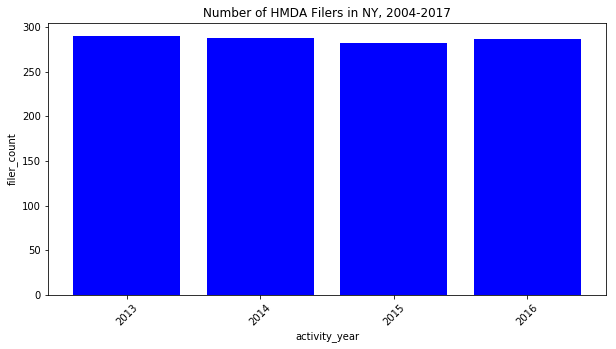

In [32]:
#Create a bar chart using the function defined above.
#Save the graph output to a PNG file.
plt = bar_chart(x_data=time_series_df['activity_year'], y_data=time_series_df['filer_count'],
         title="Number of HMDA Filers in NY, 2004-2017", figsize=(10,5))
plt.savefig('analysis_output/charts/2_filer_count_by_category.png') 